### Example use of time-dependent global sensitivity analysis (TDGSA) package

We show the use of the TDGSA package on a simple oscillator example from Alexanderian et al [1]. The oscillator model is governed by the IVP

$\frac{d^2y}{dt^2} + 2\alpha\frac{dy}{dt}+(\alpha^2+\beta^2)y=0$,

$y(0) = \ell, \, \, \frac{dy(0)}{dt}=0$.

The parameters $\alpha$, $\beta$, and $\ell$ are uncertain and distributed according to

$\alpha \sim \mathcal{U}(\frac{3}{8}, \frac{5}{8})$,

$\beta \sim \mathcal{U}(\frac{10}{4}, \frac{15}{4})$,

$\ell \sim \mathcal{U}(-\frac{5}{4}, -\frac{3}{4})$.

[1] Alexanderian, A.; Gremaud, P. A.; Smith, R. C. Variance-Based Sensitivity Analysis for Time-Dependent Processes. Reliability Engineering & System Safety 2020, 196, 106722. https://doi.org/10.1016/j.ress.2019.106722.


In [3]:
from TDGSA import simulator, distribution, time_dependent_sensitivity_analysis

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

#===============================================================================#
# Define the parameter distribution and model of interest
#===============================================================================#

NUM_TIMESTEPS_SOLVER = 200
num_timesteps_quadrature = 100
num_samples = 150

def my_model_numeric(param):
    def derivatives(x, t):
        return [x[1],-2*param[0]*x[1]-(param[0]**2 + param[1]**2)*x[0]]
    time = np.linspace(0,10,NUM_TIMESTEPS_SOLVER)
    displacement, velocity = odeint(derivatives, [param[2],0], time).T
    return displacement

## choose the analytic model to speed up computation
def my_model_analytic(param):
    time = np.linspace(0,10,NUM_TIMESTEPS_SOLVER)
    displacement = param[2]*np.exp(-param[0]*time)*(np.cos(param[1]*time)+param[0]/param[1]*np.sin(param[1]*time))
    return displacement


my_dist_dict = {
    r"$\alpha$": ("uniform", [3/8, 5/8]),
    r"$\beta$": ("uniform", [10/4, 15/4]),
    r"$\ell$": ("uniform", [-5/4, -3/4])
}

my_distribution = distribution(my_dist_dict)
my_simulator = simulator(my_model_numeric, timesteps_solver=np.linspace(0,10,NUM_TIMESTEPS_SOLVER))
my_tdsa = time_dependent_sensitivity_analysis(my_simulator, my_distribution, num_timesteps_quadrature=num_timesteps_quadrature)

my_params, my_output = my_tdsa.sample_params_and_run_simulator(num_samples)

Sampling parameters ...

Running simulator ...



  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [00:03<00:00, 4158.24it/s]


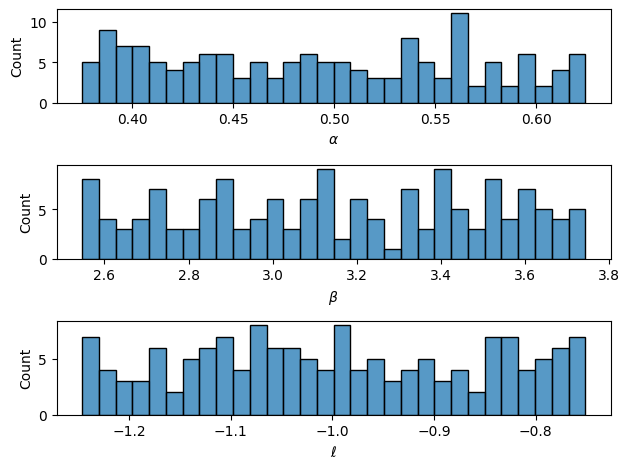

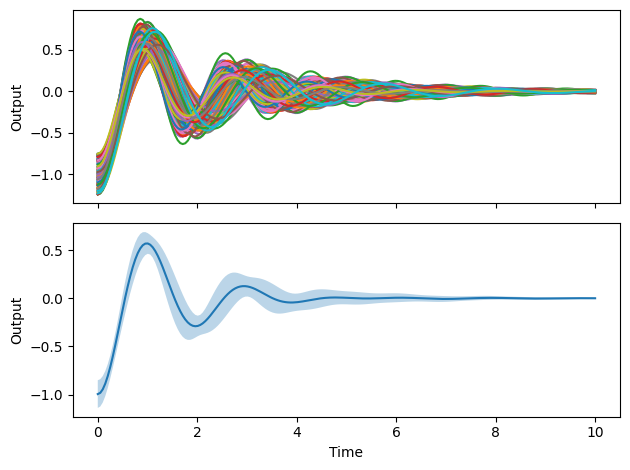

In [2]:
## Plot parameters
fig, axes = plt.subplots(3,1)
for i, ax in enumerate(axes):
    sns.histplot(data=my_simulator.params[my_simulator.dist.param_names[i]], bins=30, ax=ax)
plt.tight_layout()

## Plot output
my_simulator.plot_output()

,first,total
$\alpha$,0.019476,0.032859
$\beta$,0.856023,0.886551
$\ell$,0.086941,0.084642


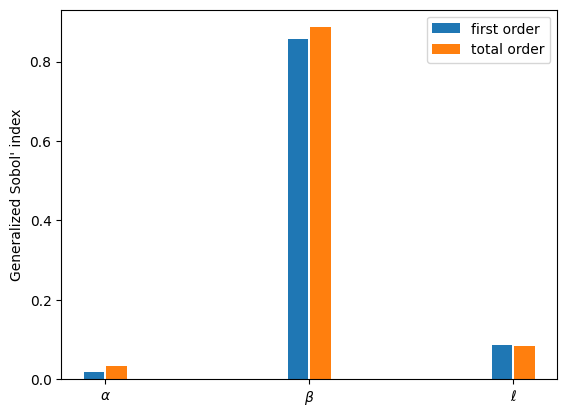

In [3]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'KL'
#===============================================================================#

my_method = "KL" # use KL method to compute the sensitivity indices

my_tds = time_dependent_sensitivity(my_simulator, my_method)

sobol_indices_KL = my_tds.compute_sobol_indices()

my_tds.plot_sobol_indices()

sobol_indices_KL

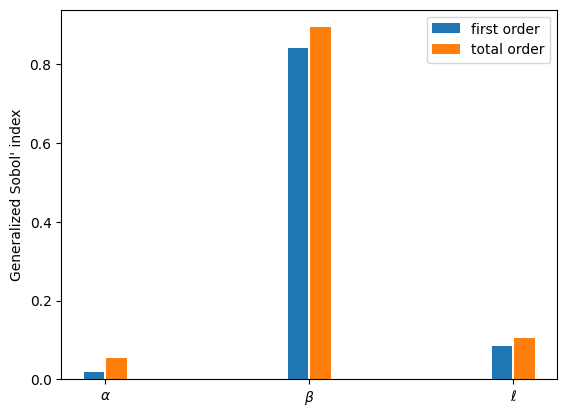

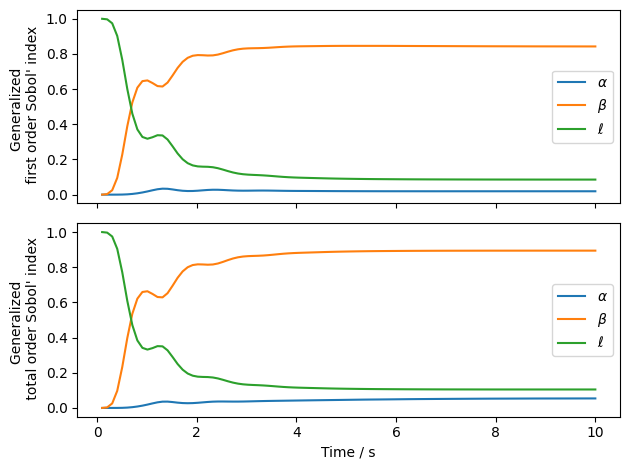

In [4]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'PCE'
#===============================================================================#

my_method = "PCE" # use PCE method to compute the sensitivity indices

my_tds = time_dependent_sensitivity(my_simulator, my_method)

sobol_indices_PCE = my_tds.compute_sobol_indices()

my_tds.plot_sobol_indices()

my_tds.plot_time_dependent_sobol_indices()

In [5]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'MC'
#===============================================================================#

# my_method = "MC" # use MC method to compute the sensitivity indices
# 
# my_tds = time_dependent_sensitivity(my_simulator, my_method)
# 
# sobol_indices_MC = my_tds.compute_sobol_indices()
# 
# my_tds.plot_sobol_indices()
# 
# my_tds.plot_time_dependent_sobol_indices()

Text(0, 0.5, "Generalized total order Sobol' indices")

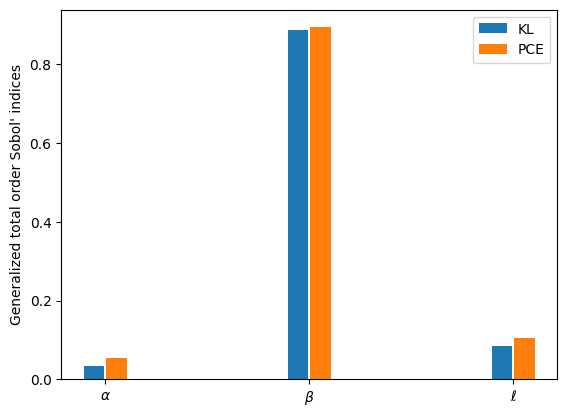

In [6]:
#===============================================================================#
# Compare the time-dependent sensitivity indices computed using different methods
#===============================================================================#

plt.figure()
x = np.array([1,2,3])
plt.bar(x-0.055, sobol_indices_KL["total"], width=0.1, label="KL")
plt.bar(x+0.055, sobol_indices_PCE["total"], width=0.1, label="PCE")
plt.xticks([1,2,3], [r"$\alpha$", r"$\beta$", r"$\ell$"])
plt.legend()
plt.ylabel("Generalized total order Sobol' indices")

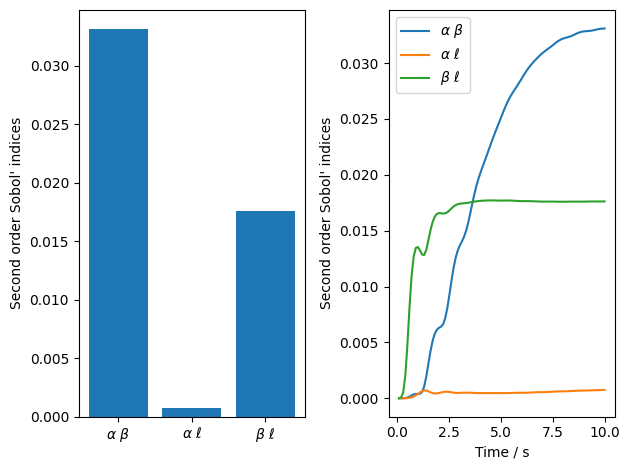

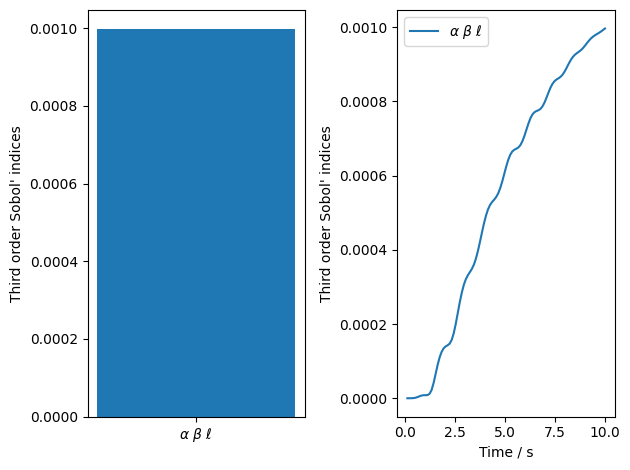

In [7]:
## Compute second and third order sobol indices

second_order_sobol_indices, td_second_order_sobol_indices, param_combinations_sec = my_tds.compute_second_order_sobol_indices()
third_order_sobol_indices, td_third_order_sobol_indices, param_combinations_third = my_tds.compute_third_order_sobol_indices()

fig, axes = plt.subplots(1,2)
x = np.arange(1, len(param_combinations_sec)+1)
axes[0].bar(x, second_order_sobol_indices)
axes[0].set_xticks(x, param_combinations_sec)
axes[0].set_ylabel("Second order Sobol' indices")

for i in range(len(param_combinations_sec)):
    axes[1].plot(np.linspace(0,10,num_timesteps_quadrature), td_second_order_sobol_indices[:,i], label=param_combinations_sec[i])
axes[1].set_xlabel("Time / s")
axes[1].set_ylabel("Second order Sobol' indices")
axes[1].legend()
plt.tight_layout()

fig, axes = plt.subplots(1,2)
x = np.arange(1, len(param_combinations_third)+1)
axes[0].bar(x, third_order_sobol_indices)
axes[0].set_xticks(x, param_combinations_third)
axes[0].set_ylabel("Third order Sobol' indices")

for i in range(len(param_combinations_third)):
    axes[1].plot(np.linspace(0,10,num_timesteps_quadrature), td_third_order_sobol_indices[:,i], label=param_combinations_third[i])
axes[1].set_xlabel("Time / s")
axes[1].set_ylabel("Third order Sobol' indices")
axes[1].legend()
plt.tight_layout()

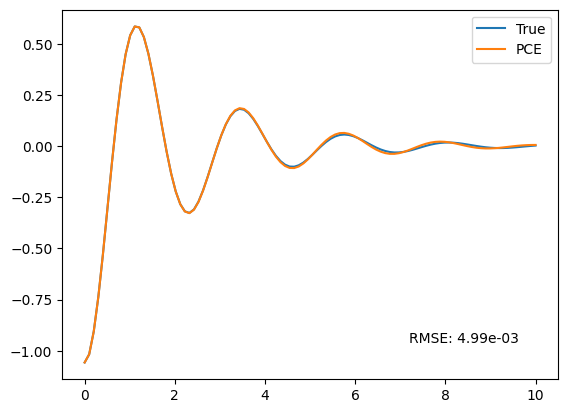

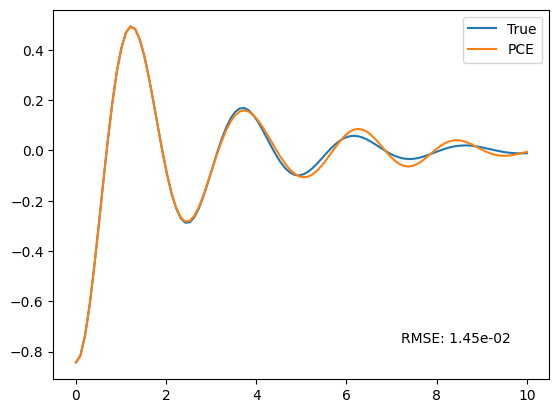

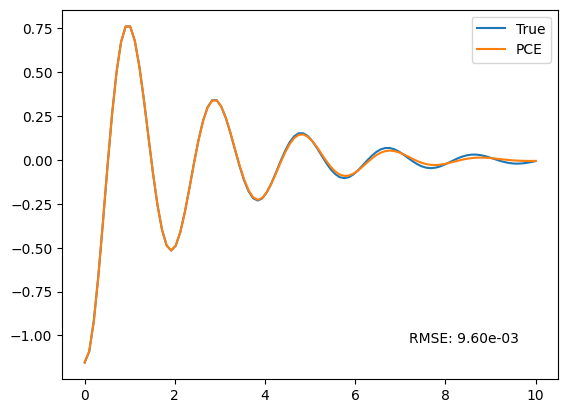

In [8]:
# Test PCE surrogate model quality

from sklearn.metrics import root_mean_squared_error

params = my_simulator.dist.sample(3)

result1 = my_simulator.model(params[0])
result2 = my_simulator.model(params[1])
result3 = my_simulator.model(params[2])

PCE_result1 = my_tds.PCE_surrogate(params[0])
PCE_result2 = my_tds.PCE_surrogate(params[1])
PCE_result3 = my_tds.PCE_surrogate(params[2])

result1 = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result1)
result2 = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result2)
result3 = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result3)

rms1 = root_mean_squared_error(result1, PCE_result1)
rms2 = root_mean_squared_error(result2, PCE_result2)
rms3 = root_mean_squared_error(result3, PCE_result3)

plt.figure()
plt.plot(np.linspace(0,10,num_timesteps_quadrature), result1, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), PCE_result1, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms1:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(np.linspace(0,10,num_timesteps_quadrature), result2, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), PCE_result2, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms2:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(np.linspace(0,10,num_timesteps_quadrature), result3, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), PCE_result3, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms3:.2e}", transform=plt.gca().transAxes)
plt.legend()
